In [1]:
%matplotlib inline

In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *

import tensorflow as tf

from keras.utils import to_categorical

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.layers import Input, Embedding
from keras.models import Model

np.random.seed(456789)

# Movie Genre Classification
## Using Deep learning to predict the genre of a movie based on it's plot

In [3]:
movie_data = pd.read_csv("../input/wikipedia-movie-plots/wiki_movie_plots_deduped.csv")

In [4]:
movie_data.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...


In [5]:
movie_data.shape

(34886, 8)

In [6]:
count_by_genre = movie_data['Genre'].groupby(movie_data['Genre']) \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False) \
                             .head(20)

In [7]:
count_by_genre

,Genre,count
2169,unknown,6083
863,drama,5964
573,comedy,4379
1390,horror,1167
7,action,1098
2114,thriller,966
1726,romance,923
2210,western,865
753,crime,568
288,adventure,526


In [8]:
genres = ['drama', 'comedy', 'horror', 'action', 'thriller',
          'romance', 'western', 'crime', 'adventure', 'musical',
          'crime drama', 'romantic comedy', 'science fiction', 'mystery', 'animation']

In [9]:
len(genres)

15

In [10]:
case = movie_data["Genre"].isin(genres)
movie_data_selected = movie_data[case]
movie_data_selected.reset_index(inplace=True)
movie_data_selected.shape

(18840, 9)

In [11]:
movie_data_selected = movie_data_selected.sort_values("Genre")

In [12]:
movie_data_selected.head()

,index,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
8561,11998,1993,Hard Target,American,John Woo,"Jean-Claude Van Damme, Lance Henriksen, Yancy ...",action,https://en.wikipedia.org/wiki/Hard_Target,"In New Orleans, a homeless veteran named Dougl..."
18160,32419,2010,Simha,Telugu,Boyapati Srinu,"Balakrishna, Nayantara, Sneha Ullal, Namitha",action,https://en.wikipedia.org/wiki/Simha_(film),Srimannarayana (Nandamuri Balakrishna) is a le...
18162,32448,2011,Parama Veera Chakra,Telugu,Dasari Narayana Rao,"Nandamuri Balakrishna, Sheela, Amisha Patel, N...",action,https://en.wikipedia.org/wiki/Parama_Veera_Chakra,Chakradhar (Nandamuri Balakrishna) is a famous...
18166,32453,2011,Wanted,Telugu,BVS Ravi,"Gopichand, Deeksha Seth, Jayasudha, Prakash Raj",action,https://en.wikipedia.org/wiki/Wanted_(2011_film),Ram Babu (Gopichand) is the only son of cute c...
18167,32454,2011,Rakshana,Telugu,Venu Pal,"Rajiv Kanakala, Karan, Parineeta",action,https://en.wikipedia.org/wiki/Rakshana,Akkineni Nagarjuna is an A.C.P. officer from V...


In [13]:
wordcounter = movie_data_selected['Plot'].apply(lambda x: x.count(' '))
print("Average number of words per plot: ", int(wordcounter.mean()))
print("Standard deviation of the words: ", int(wordcounter.std()))

Average number of words per plot:  360
Standard deviation of the words:  301


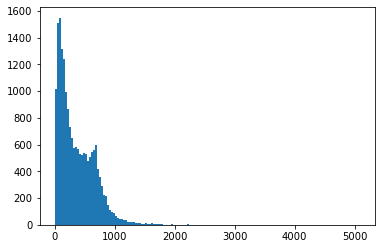

In [14]:
plt.hist(wordcounter, bins='fd')
plt.show()

In [15]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [16]:
stopwords = stopwords.words('english')

Text cleaning:
1. Convert everything to lowercase
2. Remove (\\'s)
3. Remove (\r\n)
4. Remove the text inside parenthesis ()
5. Remove punctuations and special characters
6. Remove stopwords
7. Remove short words

In [17]:
def clean_text(text):
    '''
    Clean a string input and prepare it for next steps.
    '''
    text = text.lower()
    # Find and clear all ('s)
    pattern_s = re.compile("\'s")
    text = re.sub(pattern_s, '', text)
    # Find and clear all (\r\n)
    pattern_rn = re.compile("\\r\\n")
    text = re.sub(pattern_rn, '', text)
    # Find and remove all parentheses and their contents
    pattern_parentheses = re.compile("\(.*?\)")
    text = re.sub(pattern_parentheses, '', text)
    # Find and remove punctuation and special characters
    pattern_punct = re.compile(r"[^\w\s]")
    text = re.sub(pattern_punct, '', text)
    # Broke into tokens and remove stopwords
    tokens = [w for w in text.split() if not w in stopwords]
    # Remove short words (under 3 characters) from the tokens
    long_words = []
    for token in tokens:
        if len(token) >= 3:
            long_words.append(token)
    # Join the tokens back together
    cleaned_text = (" ".join(long_words)).strip()
    return cleaned_text

In [18]:
# Clean the plot text and add it to the dataframe
cleaned_plot = []
for plot in movie_data_selected["Plot"]:
    cleaned_plot.append(clean_text(plot))

In [19]:
movie_data_selected["cleaned_plot"] = cleaned_plot

In [20]:
stemmer = PorterStemmer()
movie_data_selected["stemmed_plot"] = movie_data_selected["cleaned_plot"].str.split().apply(lambda x: ' '.join([stemmer.stem(w) for w in x]))

In [21]:
movie_data_selected.head()

,index,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot,cleaned_plot,stemmed_plot
8561,11998,1993,Hard Target,American,John Woo,"Jean-Claude Van Damme, Lance Henriksen, Yancy ...",action,https://en.wikipedia.org/wiki/Hard_Target,"In New Orleans, a homeless veteran named Dougl...",new orleans homeless veteran named douglas bin...,new orlean homeless veteran name dougla binder...
18160,32419,2010,Simha,Telugu,Boyapati Srinu,"Balakrishna, Nayantara, Sneha Ullal, Namitha",action,https://en.wikipedia.org/wiki/Simha_(film),Srimannarayana (Nandamuri Balakrishna) is a le...,srimannarayana lecturer university hyderabad l...,srimannarayana lectur univers hyderabad live g...
18162,32448,2011,Parama Veera Chakra,Telugu,Dasari Narayana Rao,"Nandamuri Balakrishna, Sheela, Amisha Patel, N...",action,https://en.wikipedia.org/wiki/Parama_Veera_Chakra,Chakradhar (Nandamuri Balakrishna) is a famous...,chakradhar famous movie actor though mother do...,chakradhar famou movi actor though mother does...
18166,32453,2011,Wanted,Telugu,BVS Ravi,"Gopichand, Deeksha Seth, Jayasudha, Prakash Raj",action,https://en.wikipedia.org/wiki/Wanted_(2011_film),Ram Babu (Gopichand) is the only son of cute c...,ram babu son cute couple ram babu janaki earne...,ram babu son cute coupl ram babu janaki earn m...
18167,32454,2011,Rakshana,Telugu,Venu Pal,"Rajiv Kanakala, Karan, Parineeta",action,https://en.wikipedia.org/wiki/Rakshana,Akkineni Nagarjuna is an A.C.P. officer from V...,akkineni nagarjuna acp officer visakhapatnam c...,akkineni nagarjuna acp offic visakhapatnam com...


In [22]:
movie_data_selected.groupby(movie_data_selected["Genre"]).size()

Genre
action             1098
adventure           526
animation           264
comedy             4379
crime               568
crime drama         464
drama              5964
horror             1167
musical             467
mystery             310
romance             923
romantic comedy     461
science fiction     418
thriller            966
western             865
dtype: int64

In [23]:
print(f"80% of the data for training: {int(movie_data_selected.shape[0]*0.8)} samples")
print(f"10% for training and 10% for validation: {int(movie_data_selected.shape[0]*0.1)} samples each")

80% of the data for training: 15072 samples
10% for training and 10% for validation: 1884 samples each


In [25]:
grouped_by_genre = movie_data_selected.groupby(movie_data_selected["Genre"], group_keys=False)

train_df = pd.DataFrame()
val_df = pd.DataFrame()
test_df = pd.DataFrame()
# Not exactly what I need, but the general idea is here
for g in genres:
    train_range = int(grouped_by_genre.get_group(g).shape[0]*0.8)
    val_range = int(grouped_by_genre.get_group(g).shape[0]*0.9)
    train_df = train_df.append(grouped_by_genre.get_group(g).iloc[0:train_range, :])
    val_df = val_df.append(grouped_by_genre.get_group(g).iloc[train_range:val_range, :])
    test_df = test_df.append(grouped_by_genre.get_group(g).iloc[val_range:, :])
# Combine in one dataframe
comb_df = pd.DataFrame()
comb_df = comb_df.append(train_df)
comb_df = comb_df.append(val_df)
comb_df = comb_df.append(test_df)

In [28]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)
print(comb_df.shape)

(15066, 11)
(1884, 11)
(1890, 11)
(18840, 11)


In [29]:
# Initalise tokenizer with the original data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(list(comb_df["Plot"]))
sequences = tokenizer.texts_to_sequences(list(comb_df["Plot"]))
max_len = np.max([len(sequence) for sequence in sequences])
print("Maximum length sequence is", max_len)
word_index = tokenizer.word_index
print(f"{len(word_index)} unique tokens have been found.")
token_data = pad_sequences(sequences, maxlen=max_len, padding='post')
print("Shape of the token data tensor:", token_data.shape)

Maximum length sequence is 5204
115737 unique tokens have been found.
Shape of the token data tensor: (18840, 5204)


In [30]:
# With the cleaned data
tokenizer_clean = Tokenizer()
tokenizer_clean.fit_on_texts(list(comb_df["stemmed_plot"]))
sequences_clean = tokenizer_clean.texts_to_sequences(list(comb_df["stemmed_plot"]))
max_len_clean = np.max([len(sequence) for sequence in sequences_clean])
print("Maximum length sequence is", max_len_clean)
word_index_clean = tokenizer_clean.word_index
print(f"{len(word_index_clean)} unique tokens have been found.")
token_data_clean = pad_sequences(sequences_clean, maxlen=max_len_clean, padding='post')
print("Shape of the token data tensor:", token_data_clean.shape)

Maximum length sequence is 2734
118167 unique tokens have been found.
Shape of the token data tensor: (18840, 2734)


In [31]:
token_data[1952]

array([    7, 17853,     7, ...,     0,     0,     0], dtype=int32)

It looks like the tokenizer with the cleaned data found a little more unique tokens than the other. Maybe for now we will use the one with the original data.

In [32]:
sanity_check_index = {v: k for k, v in tokenizer.word_index.items()}
print(sequences[100])
print(' '.join([sanity_check_index[word_index] for word_index in sequences[100]]))
print(token_data[100][0])
print(token_data[100][-1])
print(' '.join([sanity_check_index[word_index] for word_index in token_data[100] if word_index!=0]))

[1, 84, 6, 26, 25358, 2203, 5, 515, 43339, 68, 23, 1096, 2078, 77, 1, 1711, 44, 57, 1606, 1, 142, 6, 8162, 17, 4994, 25359, 18, 26, 2402, 191, 15764, 1, 142, 19, 4, 1541, 3, 13087, 19, 1, 142, 43, 25338, 35, 43, 26807, 21, 22, 30, 8, 82, 891, 2068, 974, 6184, 37, 4, 1312, 893, 7, 2068, 1798, 7, 11740, 47, 16, 666, 330, 26, 4245, 3687, 3, 178, 13, 2, 1498, 4, 671, 68, 7, 2945, 315, 10, 109, 471, 2438, 6184, 3, 97, 191, 3637, 17697, 26, 1244, 8532, 5, 1914, 269, 891, 343, 260, 2568, 186, 2, 4915, 244, 12, 1435, 2566, 61, 1323, 7, 12, 330, 133, 14, 1, 142, 134, 1574, 135, 29, 28, 2649, 25360, 2, 2945, 12, 1, 71, 586, 2, 4359, 60, 7, 8915, 4359, 82, 5426, 11741, 2645, 21, 6, 12581, 5, 1, 71, 24, 1348, 7, 27, 330, 111, 19, 4, 1578, 5, 1852, 891, 3, 5426, 1197, 15, 526, 78, 1, 60, 139, 891, 134, 2, 44, 26, 395, 12, 214, 26808, 5925, 5364, 1, 97, 5, 1, 173, 1435, 22030, 21, 6, 7, 8, 16634, 9, 684, 7, 12, 891, 21, 49, 5426, 9, 6, 10, 8051, 97, 891, 3, 10, 211, 30, 151, 4397, 32, 27, 5426, 67, 

In [76]:
train_data = token_data[0:train_range]
val_data = token_data[train_range:val_range]
test_data = token_data[val_range:]

train_labels = train_df["Genre"]
val_labels = val_df["Genre"]
test_labels = test_df["Genre"]

In [77]:
train_labels.value_counts()

drama              4771
comedy             3503
horror              933
action              878
thriller            772
romance             738
western             692
crime               454
adventure           420
musical             373
crime drama         371
romantic comedy     368
science fiction     334
mystery             248
animation           211
Name: Genre, dtype: int64

In [78]:
val_labels.value_counts()

drama              596
comedy             438
horror             117
action             110
thriller            97
romance             92
western             86
crime               57
adventure           53
musical             47
romantic comedy     46
crime drama         46
science fiction     42
mystery             31
animation           26
Name: Genre, dtype: int64

In [79]:
test_labels.value_counts()

drama              597
comedy             438
horror             117
action             110
thriller            97
romance             93
western             87
crime               57
adventure           53
romantic comedy     47
musical             47
crime drama         47
science fiction     42
mystery             31
animation           27
Name: Genre, dtype: int64

In [80]:
train_labels = pd.factorize(train_labels)
val_labels = pd.factorize(val_labels)
test_labels = pd.factorize(test_labels)

In [81]:
train_labels = to_categorical(train_labels[0], num_classes=len(genres))
val_labels = to_categorical(val_labels[0], num_classes=len(genres))
test_labels = to_categorical(test_labels[0], num_classes=len(genres))

In [82]:
train_labels.shape

(15066, 15)

### GloVe

In [83]:
embeddings = {}
index = 0
with open ('../input/glove-global-vectors-for-word-representation/glove.6B.100d.txt') as file:
    for embedding_line in file:
        line_split = embedding_line.split()
        coefs = np.asarray(line_split[1:], dtype='float32')
        embeddings[line_split[0]] = coefs
        index += 1

In [84]:
embeddings_matrix = np.zeros((len(word_index)+1, len(embeddings['a'])))
for word, i in word_index.items():
    if word in embeddings:
        embeddings_matrix[i] = embeddings[word]

In [88]:
print('Word #125', sanity_check_index[125])
print('Index of if', word_index['if'])
print('Embedding in embeddings list: ', embeddings['if'][:5])
print('Embedding in embeddings matrix: ', embeddings_matrix[125][:5])

Word #125 if
Index of if 125
Embedding in embeddings list:  [-0.26269  0.6424   0.84803 -0.46166 -0.78775]
Embedding in embeddings matrix:  [-0.26269001  0.64240003  0.84802997 -0.46166    -0.78775001]


In [90]:
embedding_layer = Embedding(len(word_index)+1, 
                            len(embeddings['a']), 
                            weights=[embeddings_matrix], 
                            input_length=max_len, 
                            trainable=False)
embedding_layer_without_GloVe = Embedding(len(word_index)+1, 
                                          len(embeddings['a']), 
                                          weights=[embeddings_matrix], 
                                          input_length=max_len)

In [95]:
# Check the layer
sequence_input = Input(shape=(max_len,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
embedding_only_Model = Model(sequence_input, embedded_sequences)

print('Manual Embeddings Result: ', [list(embeddings[sanity_check_index[x]][:3]) if sanity_check_index[x] in embeddings else [0, 0, 0] for x in sequences[500]][-5:])
print()
print('Model Embeddings Result: ', embedding_only_Model.predict(np.array(token_data[500]).reshape(1, max_len))[0, -5:, :3])

Manual Embeddings Result:  [[-0.30964, 0.69, 1.2633], [-0.1897, 0.050024, 0.19084], [-0.037608, 0.15683, 0.4796], [0.3339, -0.52136, 0.26848], [-0.44986, 1.2823, -1.1963]]

Model Embeddings Result:  [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


In [96]:
token_data[500]

array([ 1192, 11583,   881, ...,     0,     0,     0], dtype=int32)

TODO:
1. Sanity check of the tokenizer - DONE
2. Train-test-split - DONE
3. GloVe emeddings
4. LSTM-CNN model
